In [1]:
import os
import math
import glob
import wfdb
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from scipy import signal
from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1658497162847124986)

data_directory = "./data/CEBS/m001"
model_directory = './models/'
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_dbs =        [0, 0.5, 1, 5, 7, 10]
target_snr_weights =    (10, 10, 10)

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [3]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / (np.sum((signal_noisy - signal_clean) ** 2)))

def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_noisy - signal_clean) ** 2) / np.sum(signal_clean ** 2)) * 100

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy, mode='same')

In [4]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data

In [5]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    return data

In [6]:
# https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

def add_gaussian(data, target_snr_dbs):

    # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
    # target_snr_db = random.choice(target_snr_dbs)
    target_snr_db = random.uniform(0, 30) # sample from bigger range provides better results?
    # target_snr_db = 1

    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = np.mean(data)
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

def normalize(x, min_val, max_val):
    y = (x-min_val) / (max_val - min_val)
    return y


def bandpass(input_signal):
    # https://www.youtube.com/watch?v=juYqcck_GfU
    fs = 100.0 # frequency space
    lowcut = 5.0 # Hz
    highcut = 30.0 # Hz

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

In [7]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        self.min_val = 0
        self.max_val = np.inf

        data = load_datasets('./data/CEBS/')
        #data = data.resample(sampling_rate).mean().SCG

        # data_noise = data.apply(lambda x: bandpass(x))
        data_noise = data.apply(lambda x: add_gaussian(x, target_snr_dbs))
        data = pd.DataFrame({'clean': data, 'noise': data_noise})

        #data_concat = np.concatenate([np.concatenate(data.values[0]), np.concatenate(data.values[1])])
        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        self.min_val = np.min(data.values.tolist())
        self.max_val = np.max(data.values.tolist())

        for column in data.columns:
            data[column] = data[column].apply(lambda x: normalize(x, self.min_val, self.max_val))
            # data[column] = (data[column] - self.min_val) / (self.max_val - self.min_val)
            
        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        #data['clean'] = data['clean'].apply(lambda x: np.array(x))
        #data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [8]:
def reverse2(x, min_val, max_val):
    return max_val * x - x * min_val + min_val

dataset = SCGData(transform=ToTensor())

In [9]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 3, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 3, stride=1), 
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), 1, 3, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 8, 1016]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1022]
│    └─BatchNorm1d: 2-2                  [32, 128, 1022]           [32, 128, 1022]
│    └─ELU: 2-3                          [32, 128, 1022]           [32, 128, 1022]
│    └─Conv1d: 2-4                       [32, 128, 1022]           [32, 32, 1020]
│    └─BatchNorm1d: 2-5                  [32, 32, 1020]            [32, 32, 1020]
│    └─ELU: 2-6                          [32, 32, 1020]            [32, 32, 1020]
│    └─Conv1d: 2-7                       [32, 32, 1020]            [32, 16, 1018]
│    └─BatchNorm1d: 2-8                  [32, 16, 1018]            [32, 16, 1018]
│    └─ELU: 2-9                          [32, 16, 1018]            [32, 16, 1018]
│    └─Conv1d: 2-

In [37]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 7, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 7, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 7, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 7, stride=1),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 7, stride=1), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 1000]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1018]
│    └─BatchNorm1d: 2-2                  [32, 128, 1018]           [32, 128, 1018]
│    └─ELU: 2-3                          [32, 128, 1018]           [32, 128, 1018]
│    └─Conv1d: 2-4                       [32, 128, 1018]           [32, 64, 1012]
│    └─BatchNorm1d: 2-5                  [32, 64, 1012]            [32, 64, 1012]
│    └─ELU: 2-6                          [32, 64, 1012]            [32, 64, 1012]
│    └─Conv1d: 2-7                       [32, 64, 1012]            [32, 32, 1006]
│    └─BatchNorm1d: 2-8                  [32, 32, 1006]            [32, 32, 1006]
│    └─ELU: 2-9                          [32, 32, 1006]            [32, 32, 1006]
│    └─Conv1d: 2-

In [12]:
class DeNoiseNone(nn.Module):
    def __init__(self, kernel_size=16, filters_1=64, filters_2=32):
        super(DeNoise2, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 968]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1010]
│    └─BatchNorm1d: 2-2                  [32, 128, 1010]           [32, 128, 1010]
│    └─ELU: 2-3                          [32, 128, 1010]           [32, 128, 1010]
│    └─Conv1d: 2-4                       [32, 128, 1010]           [32, 64, 996]
│    └─BatchNorm1d: 2-5                  [32, 64, 996]             [32, 64, 996]
│    └─ELU: 2-6                          [32, 64, 996]             [32, 64, 996]
│    └─Conv1d: 2-7                       [32, 64, 996]             [32, 32, 982]
│    └─BatchNorm1d: 2-8                  [32, 32, 982]             [32, 32, 982]
│    └─ELU: 2-9                          [32, 32, 982]             [32, 32, 982]
│    └─Conv1d: 2-10     

In [13]:
num_epochs = 10000
train_dataset, test_dataset = load_data()

In [26]:
def train(config, train_dataset, model_num, is_tune=False, checkpoint_dir=None, data_dir=None):

    if model_num in [1]:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num in [2, 3]:
        model = DeNoise2(layer_size=config['layer_size'])
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    if checkpoint_dir != None:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):\

            if model_num == 3:
                inputs = denoise_wavelet(inputs.numpy(), method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                inputs = torch.from_numpy(inputs)

            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):

            if model_num == 3:
                inputs = denoise_wavelet(inputs.numpy(), method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                inputs = torch.from_numpy(inputs)

            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss

                if model_num == 1:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_1.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_1.csv') 
                elif model_num == 2:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_2.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_2.csv')
                elif model_num == 3:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_3.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_3.csv')  

In [15]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 48 # sample data multiple times
max_num_epochs = 128

config = {
    'lr': tune.loguniform(1e-5, 1e-2),
    'wd': 0,
    'batch_size': tune.choice([8]),
    'layer_size': tune.choice([128])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
# result = tune.run(
    partial(train, train_dataset=train_dataset, model_num=1, is_tune=True, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

IndentationError: unexpected indent (2916351885.py, line 16)

In [39]:
# train({'lr': 0.0001, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 1)
train({'lr': 0.0001, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 2)
# train({'lr': 0.0005, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 3)

epoch 1 / 10000, train loss = 0.0007697582, val loss = 0.0000712979
	val loss decreased from inf to 0.0098391119
epoch 2 / 10000, train loss = 0.0000358320, val loss = 0.0000206104
	val loss decreased from 0.0098391119 to 0.0028442329
epoch 3 / 10000, train loss = 0.0000124828, val loss = 0.0000115163
	val loss decreased from 0.0028442329 to 0.0015892528
epoch 4 / 10000, train loss = 0.0000068221, val loss = 0.0000079714
	val loss decreased from 0.0015892528 to 0.0011000490
epoch 5 / 10000, train loss = 0.0000050925, val loss = 0.0000075609
	val loss decreased from 0.0011000490 to 0.0010433982
epoch 6 / 10000, train loss = 0.0000048604, val loss = 0.0000074537
	val loss decreased from 0.0010433982 to 0.0010286070
epoch 7 / 10000, train loss = 0.0000049606, val loss = 0.0000074058
	val loss decreased from 0.0010286070 to 0.0010219960
epoch 8 / 10000, train loss = 0.0000045797, val loss = 0.0000074539
epoch 9 / 10000, train loss = 0.0000046282, val loss = 0.0000088309
epoch 10 / 10000, t

In [28]:
def save_results(results):

    if not os.path.exists('./results'):
        os.mkdir('./results')

    # run_name = str(len(os.listdir('./results')))
    # working_dir = os.path.join('./results', run_name)
    # working_dir = os.mkdir(working_dir)

    working_dir = os.path.join('./results', '0')


    # SNR
    data = [[np.mean(results[method][scope]['snr_imp']) for method in results.keys()] for scope in target_snr_dbs + ['all']]

    labels = results.keys()
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('SNR Improvement (dB)')
    plt.title('Mean SNR Improvement')
    width = 0.1

    for i in range(len(target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_dbs + ['all'])
    plt.show()


    # RMSE
    data = [[np.mean(results[method][scope]['rmse']) for method in results.keys()] for scope in target_snr_dbs + ['all']]

    labels = results.keys()
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('RMSE')
    plt.title('Mean RMSE')
    width = 0.1

    for i in range(len(target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_dbs + ['all'])
    plt.show()



    # PRD
    data = [[np.mean(results[method][scope]['prd']) for method in results.keys()] for scope in target_snr_dbs + ['all']]

    labels = results.keys()
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('PRD')
    plt.title('Mean PRD')
    width = 0.1

    for i in range(len(target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_dbs + ['all'])
    plt.show()


    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    labels = results.keys()
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    plt.show()

1806
*** AE1 ***
44
SNR IMP 4.502732575148746
RMSE 1.7510887
PRD 58.941953426057644
CPU TIME 0.0013814863182646645

1806
*** WD ***
44
SNR IMP 2.0209879631742793
RMSE 2.5043268
PRD 77.55675275217403
CPU TIME 0.0005018385227024489

1806
*** AE2 ***
44
SNR IMP 4.344122116070304
RMSE 1.8610374
PRD 59.3558167192069
CPU TIME 0.0012593367726739498

1671
*** AE1+WD ***
5
SNR IMP 5.616517044603825
RMSE 2.178861
PRD 53.56898248195648
CPU TIME 0.0018869281999286613



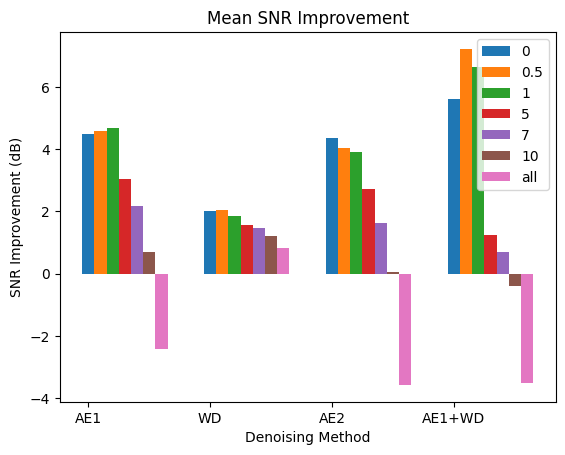

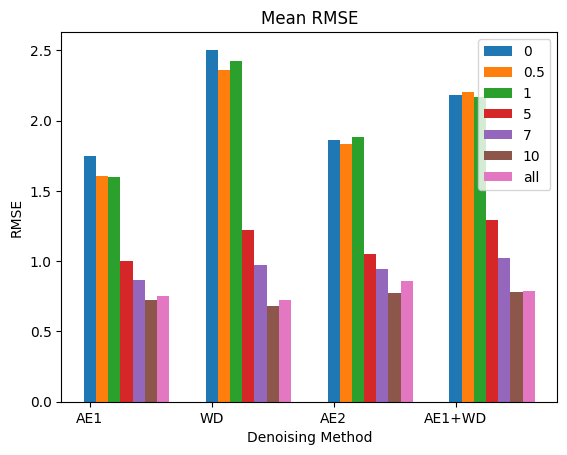

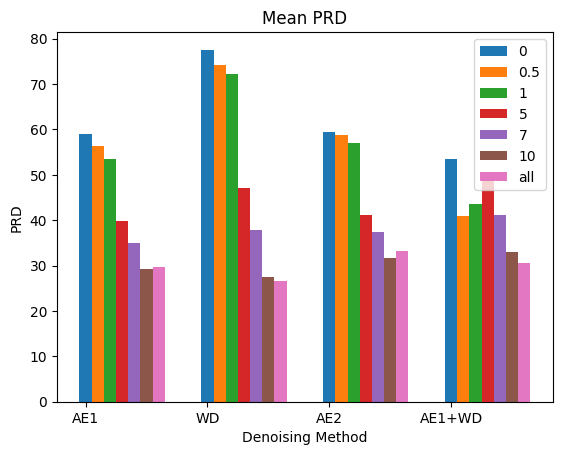

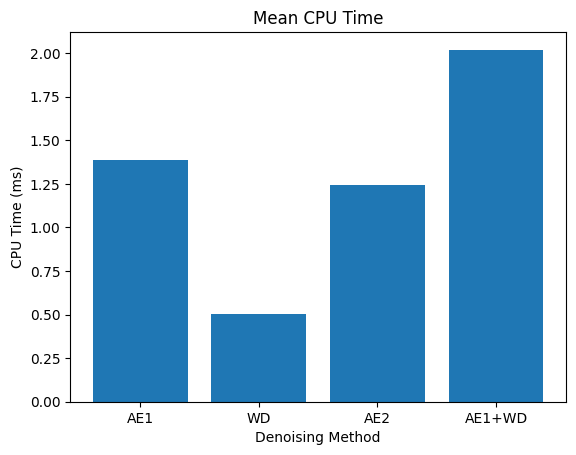

In [36]:
def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise1(layer_size=128).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
        ae1.eval()

        ae2 = DeNoise2(layer_size=128).to(device)
        ae2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))
        ae2.eval()

        ae3 = DeNoise2(layer_size=128).to(device)
        ae3.load_state_dict(torch.load(os.path.join(model_directory, 'model_3.pth')))
        ae3.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {}
            for target in target_snr_dbs + ['all']:
                results[method][target] = {
                    'result': [],
                    'snr_imp': [],
                    'rmse': [],
                    'prd': [],
                    'cpu_time': []
                }
            i = 0
            for noise, clean in test_dataset:

                cpu_time = 0

                if method == 'AE1':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                elif method == 'AE1+WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    noise = torch.from_numpy(predicted)
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                else:
                    break

                clean = clean.numpy()
                
                noise = reverse2(noise[150:850], dataset.min_val, dataset.max_val)
                predicted = reverse2(predicted[150:850], dataset.min_val, dataset.max_val)
                clean = reverse2(clean[150:850], dataset.min_val, dataset.max_val)

                snr_data = snr(clean, noise)
                for target in target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[method][target]['result'].append(predicted)
                        results[method][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[method][target]['rmse'].append([rmse(clean, predicted)])
                        results[method][target]['prd'].append([prd(clean, predicted)])
                        results[method][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 0
            print('*** ' + method + ' ***')
            print(len(results[method][value]['result']))
            print('SNR IMP ' + str(np.mean(results[method][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method][value]['rmse'])))
            print('PRD ' + str(np.mean(results[method][value]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method][value]['cpu_time'])))
            print()

        save_results(results)




config = {
    'methods': ['AE1', 'WD', 'AE2', 'AE1+WD']
}
test(config)

2.1002731
19.586102

1.1544741
3.8386536

3.8978761434555054
-5.798846483230591
-24.929168224334717

-46.64441108703613
-66.03785991668701

[-124.69777    49.888794  179.27408  ...   14.035307   94.39285
   61.502586]
[332.4527  429.0753  317.87842 ... 485.0159  498.24673 229.99234]



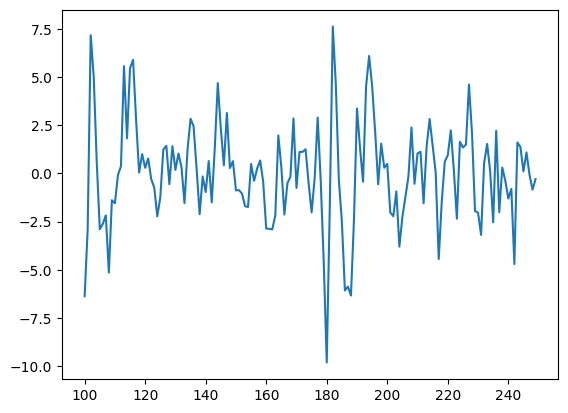

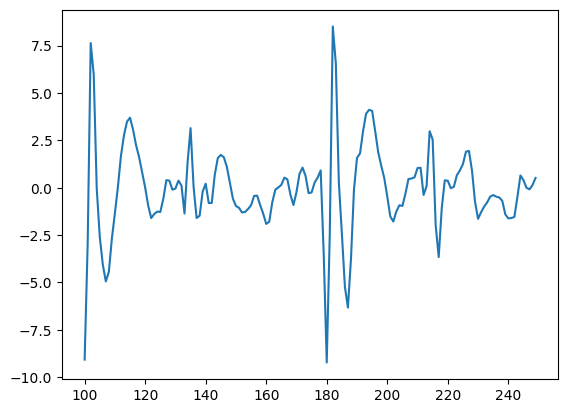

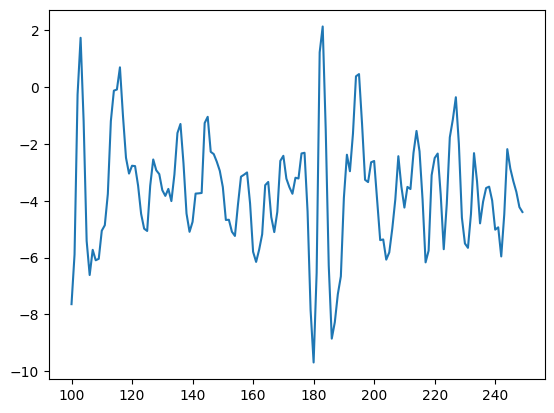

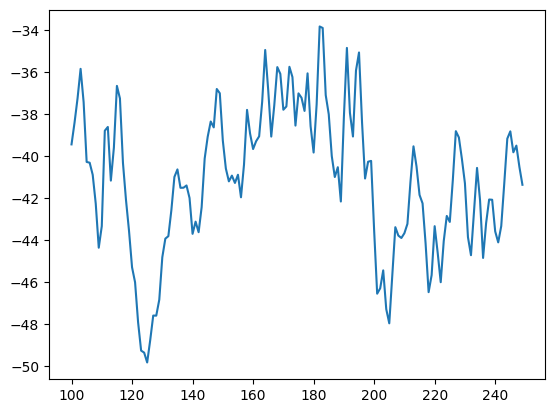

In [ ]:
model1 = DeNoise1(layer_size=128).to(device)
model1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))

model2 = DeNoise2(layer_size=128).to(device)
model2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))

model1.eval()
model2.eval()

with torch.no_grad():
    
    i = 124
    noise = test_dataset[i][0].reshape(-1, 1, segment_size_samples).to(device)
    clean = test_dataset[i][1].reshape(-1, 1, segment_size_samples).to(device)

    predicted = model1(noise).to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = model2(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    # predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

    from_val = 0
    to_val = 1024
    noise = reverse(noise[from_val:to_val])
    clean = reverse(clean[from_val:to_val])
    predicted = reverse(predicted[from_val:to_val])
    predicted2 = reverse(predicted2[from_val:to_val])

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 100
    time_to = 250

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], clean[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()